[Unsupervised representation learning with deep convolutional generative adversarial networks (2016)](https://arxiv.org/pdf/1511.06434.pdf)

In [1]:
import torch

import numpy as np
import matplotlib.pylab as plt
from tqdm import trange

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from nn import Generator, Discriminator

---

### DATA

In [3]:
def fetch(url):
    import os, requests, gzip, hashlib, numpy
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
    else:
        with open(filepath, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return numpy.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [4]:
ds = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape(-1, 28, 28) / 255.0
ds = (ds * 2) - 1 # Normalise between -1 and 1

print('Min:', np.min(ds), 'Max:', np.max(ds))

Min: -1.0 Max: 1.0


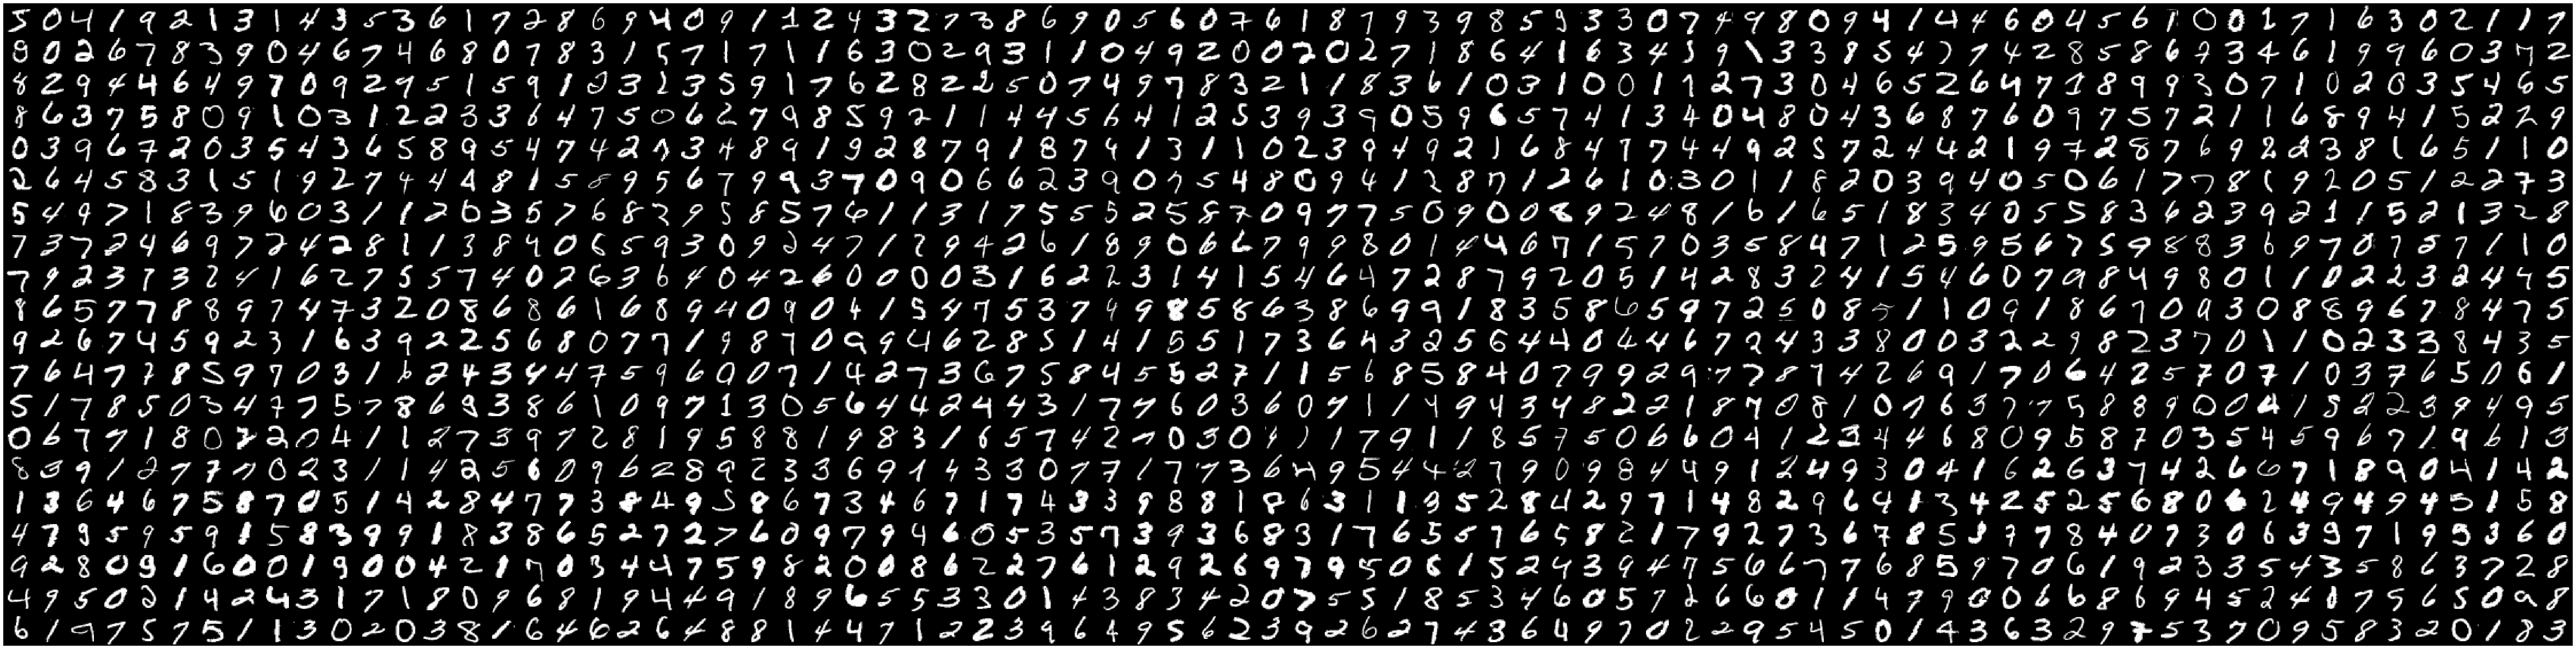

In [5]:
result = np.concatenate([np.concatenate(ds[i*80:(i+1)*80], axis=1) for i in range(20)])

plt.figure(figsize=(80,20))
plt.imshow(result, 'gray')
plt.axis('off')
plt.tight_layout()

---

### GENERATOR & DISCRIMINATOR

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
netG = Generator()
netG.apply(weights_init)

g_params = netG.parameters()
print("Nparams:", sum(p.nelement() for p in g_params))
print(netG)

Nparams: 3573696
Generator(
  (x_in): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (x_out): Sequential(
    (

In [8]:
netD = Discriminator()
netD.apply(weights_init)

d_params = netD.parameters()
print("Nparams:", sum(p.nelement() for p in d_params))
print(netD)

Nparams: 661248
Discriminator(
  (x_in): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (l1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (l2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (x_out): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Sigmoid()
  )
)


---

### TRAINING

In [9]:
loss_function = torch.nn.BCELoss()

optimD = torch.optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimG = torch.optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [10]:
bs = 128
z_dim = 100
simlen = 3000

d_lossi, g_lossi = [], []

for i in (t := trange(simlen)):
    idx = np.random.randint(0, ds.shape[0], size=bs)
    data = torch.tensor(ds[idx].reshape((-1,1,28,28))).float()
    label = torch.full((bs,), 1).float()

    # Discriminator - Real
    netD.zero_grad()
    d_real = netD(data)
    lossD_real = loss_function(d_real.squeeze(), label)
    lossD_real.backward()

    # Discriminator - Fake
    noise = torch.randn(bs, z_dim, 1, 1)
    g_fake = netG(noise)
    d_fake = netD(g_fake.detach())
    lossD_fake = loss_function(d_fake.squeeze(), label.fill_(0))
    lossD_fake.backward()
    optimD.step()

    lossD = lossD_real + lossD_fake

    # Generator
    netG.zero_grad()
    d_fake = netD(g_fake)
    lossG = loss_function(d_fake.squeeze(), label.fill_(1))
    lossG.backward()
    optimG.step()

    d_lossi.append(lossD.item())
    g_lossi.append(lossG.item())
    t.set_description("Iter: %.0f | Discriminator loss: %.2f | Generator loss: %.2f" % (i, lossD.item(), lossG.item()))

Iter: 2999 | Discriminator loss: 1.15 | Generator loss: 1.33: 100%|██████████| 3000/3000 [1:00:42<00:00,  1.21s/it]


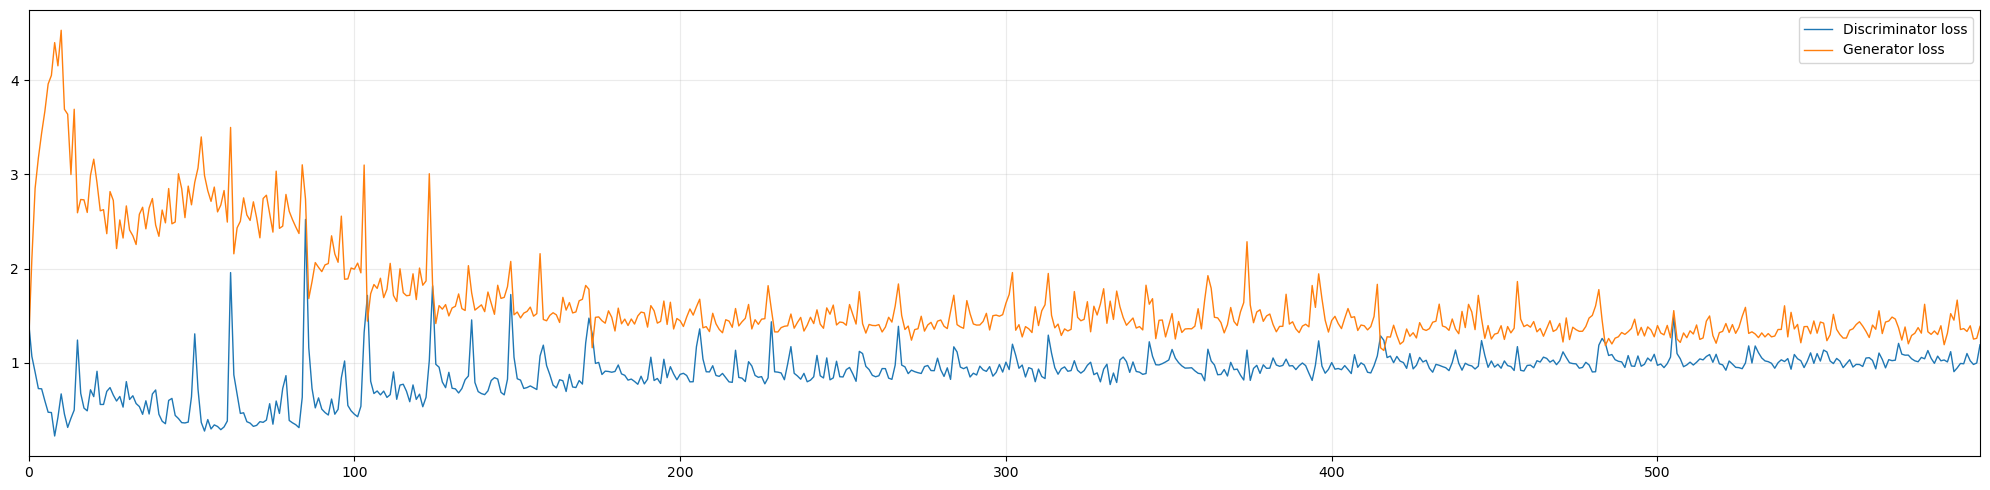

In [11]:
avg_lossD = torch.tensor(d_lossi).view(-1, 5).mean(1)
avg_lossG = torch.tensor(g_lossi).view(-1, 5).mean(1)

plt.figure(figsize=(20,5))
plt.plot(avg_lossD, lw=1, label='Discriminator loss'), plt.plot(avg_lossG, lw=1, label='Generator loss')
plt.xlim(0, len(avg_lossD)-1)
plt.grid(alpha=0.25), plt.legend()
plt.tight_layout()

---

### INFERENCE

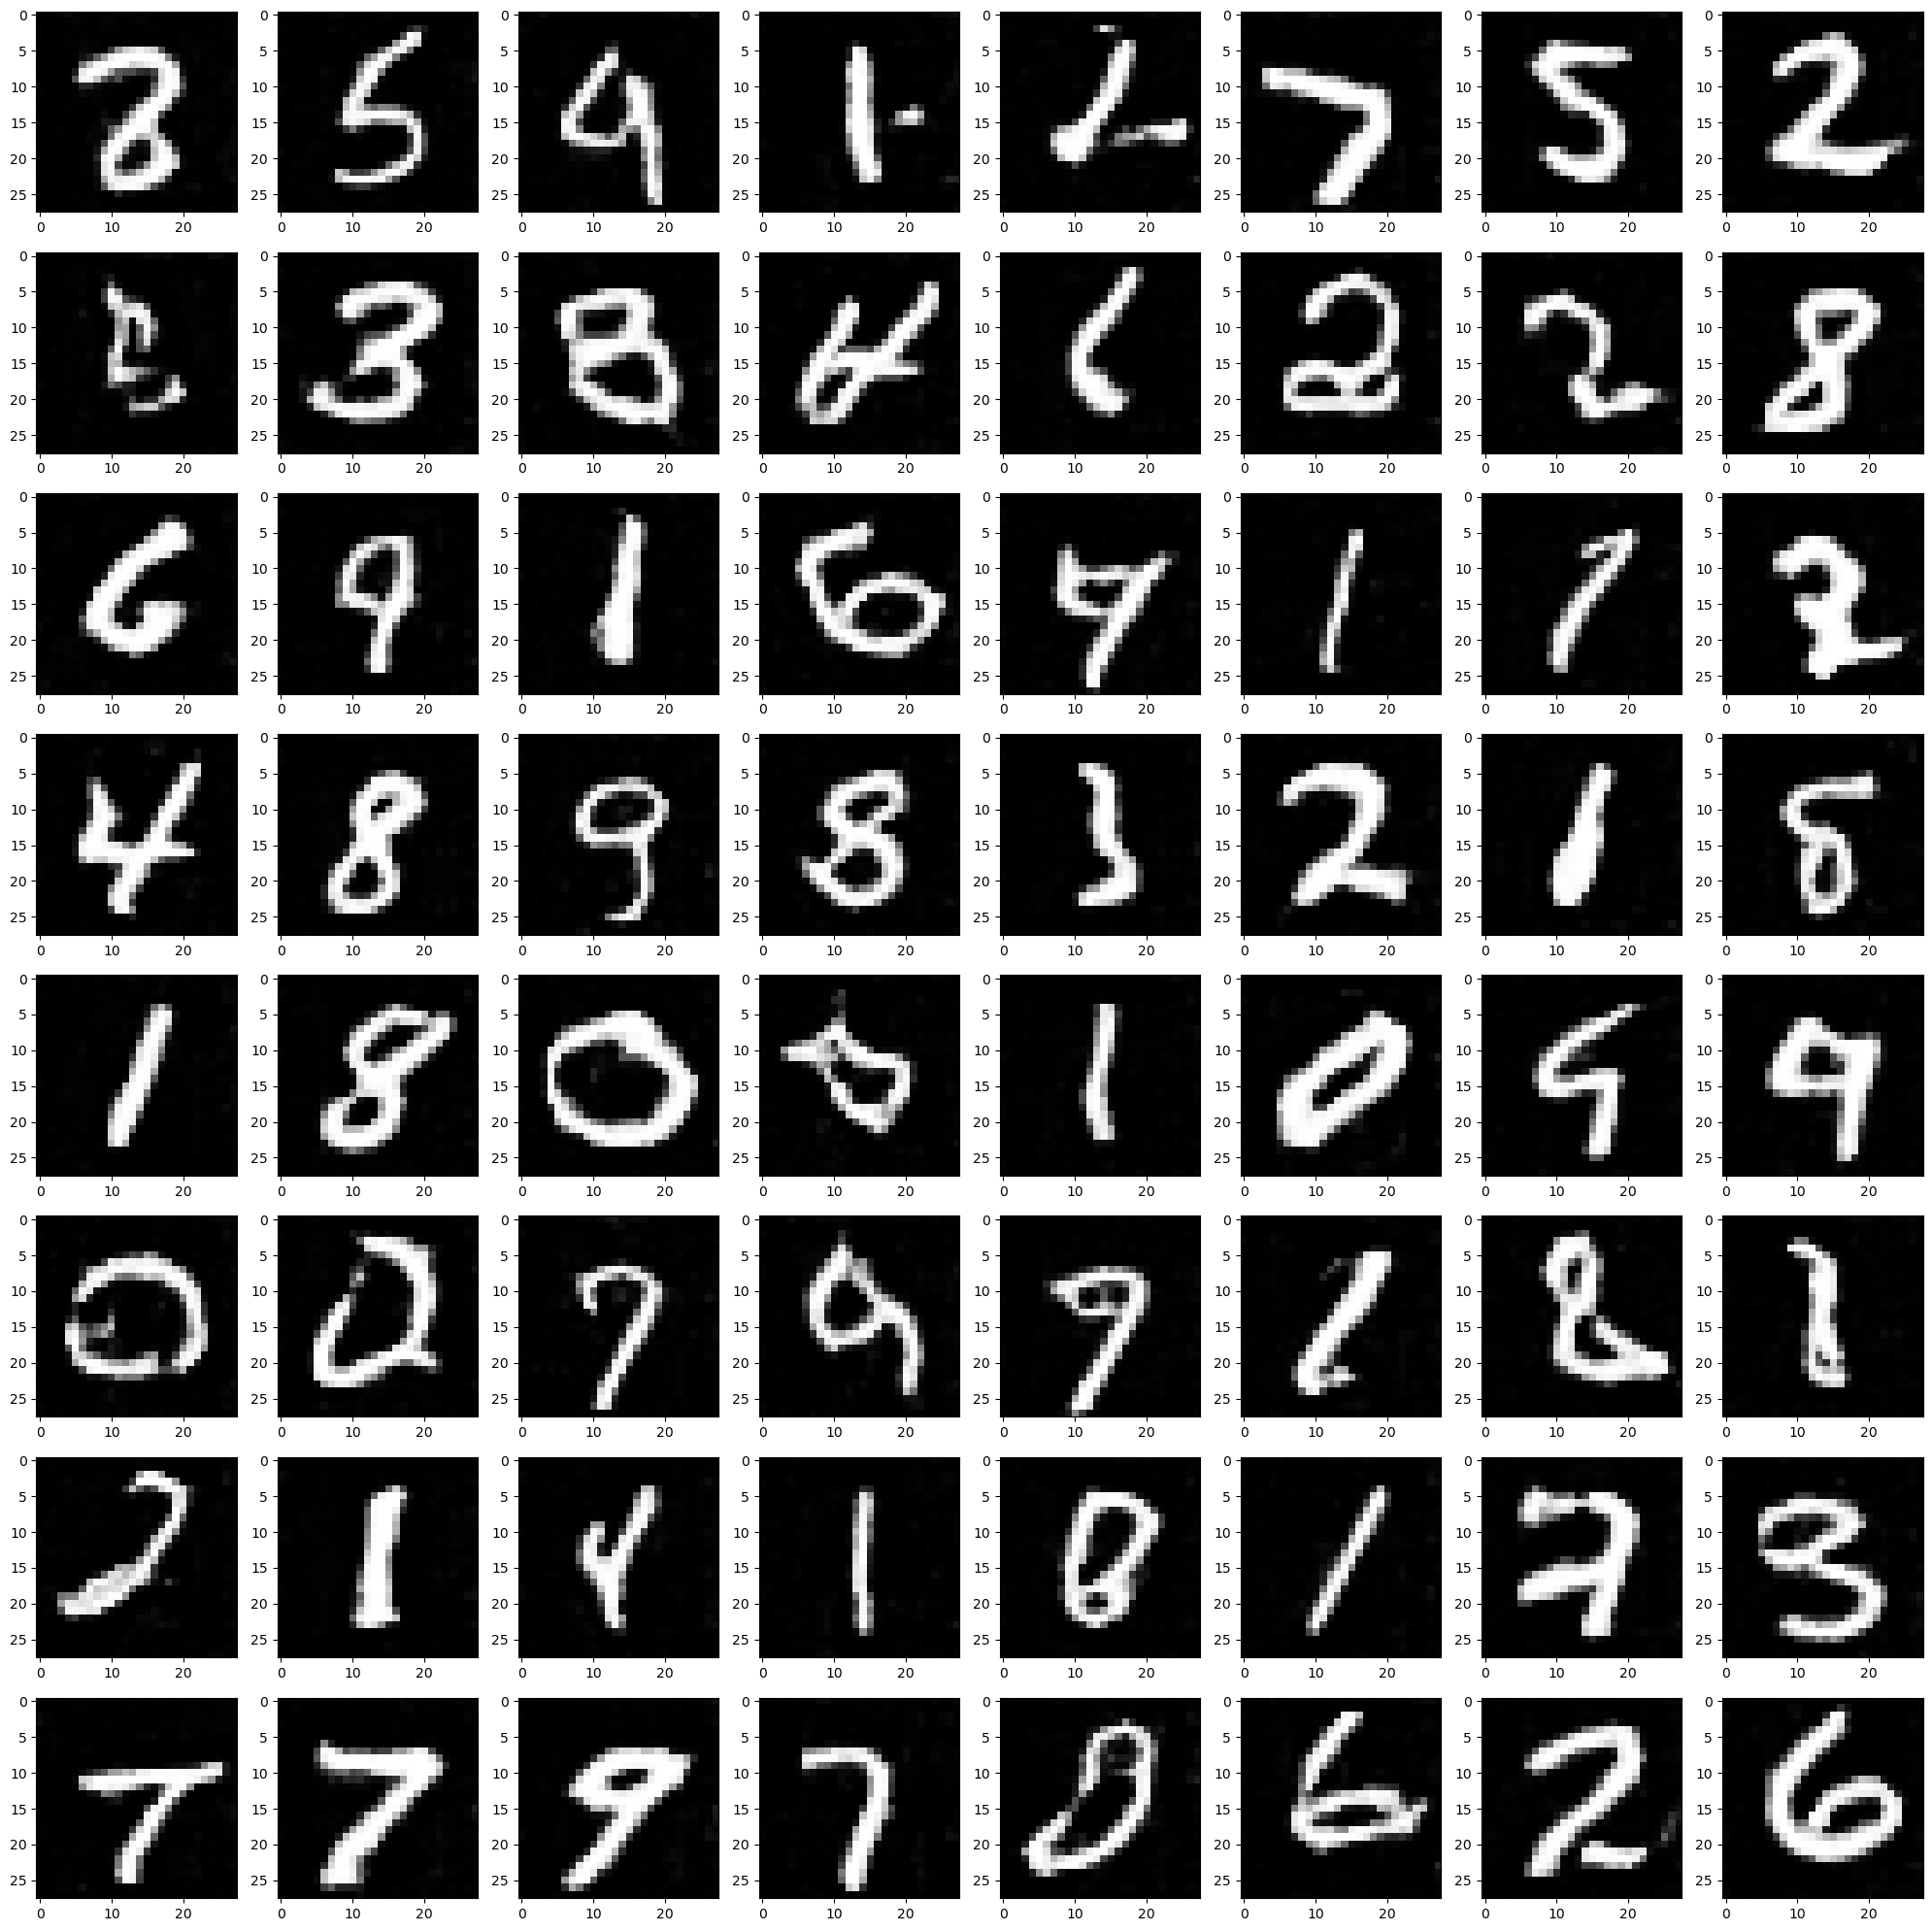

In [12]:
sample = netG(torch.randn(bs, z_dim, 1, 1))

plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample.detach()[i][0], 'gray')

plt.tight_layout()